# Running cellpose in colab with a GPU

(thanks to Matteo Carandini for setting this up)

UPDATED DEC 2020 for TORCH VERSION cellpose v0.6

## installation

Check CUDA version and GPU first

In [1]:
!nvcc --version
!nvidia-smi

'nvcc' is not recognized as an internal or external command,
operable program or batch file.
'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [2]:
!pip install cellpose

import libraries and check GPU (the first time you import cellpose the models will download).

In [3]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models

use_GPU = models.use_gpu()
print('>>> GPU activated? %d'%use_GPU)


** TORCH CUDA version installed and working. **
>>> GPU activated? 1


Download sample images

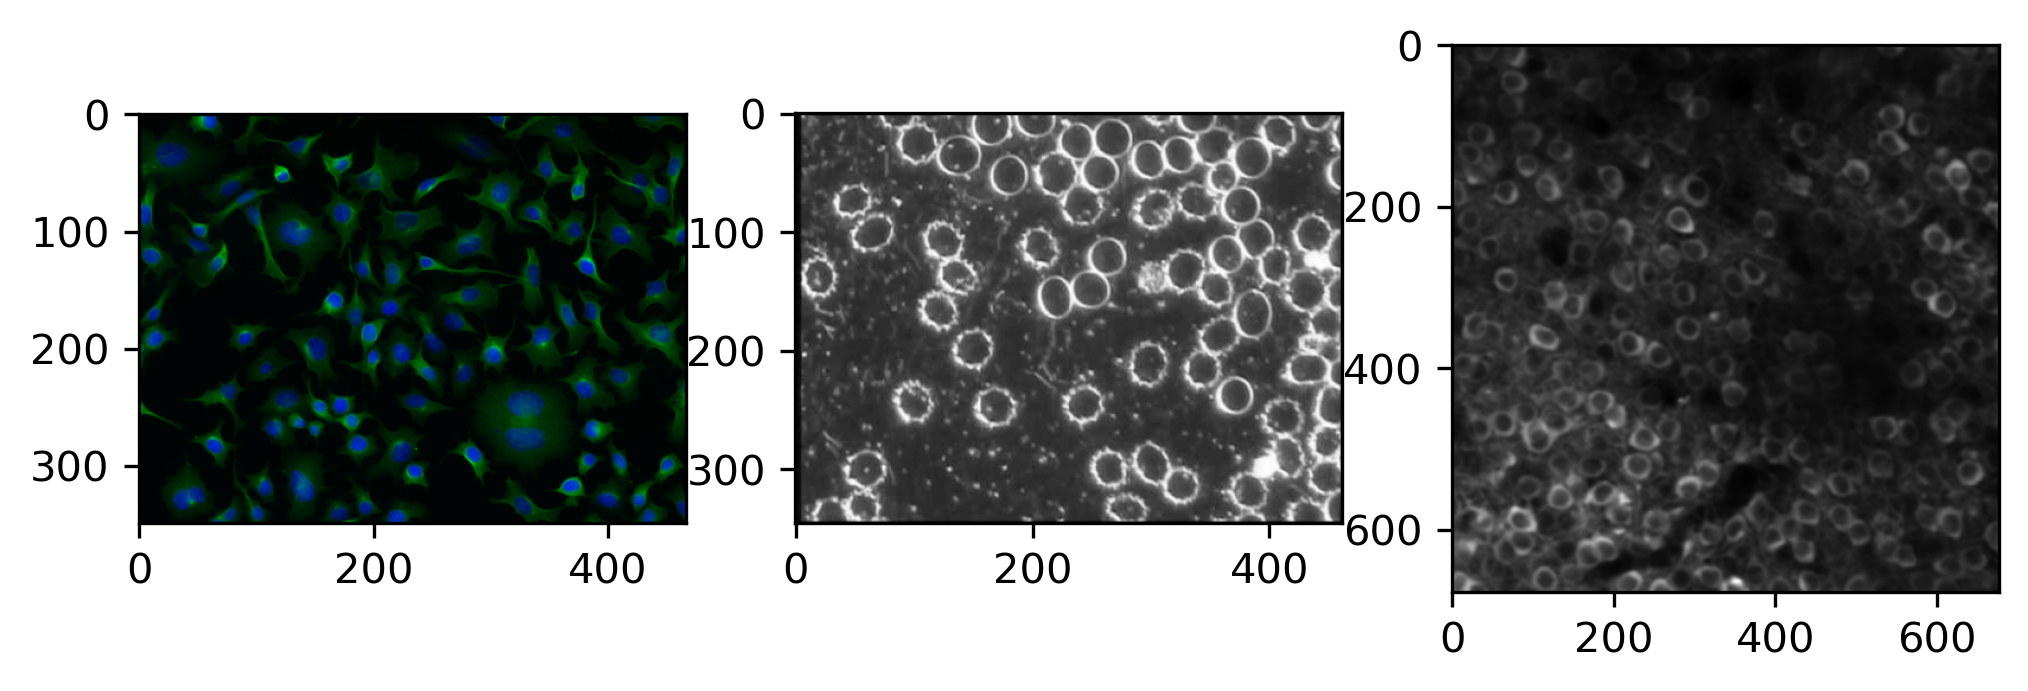

In [4]:
from cellpose import utils
# I will download images from website
urls = ['http://www.cellpose.org/static/images/img02.png',
        'http://www.cellpose.org/static/images/img03.png',
        'http://www.cellpose.org/static/images/img05.png',
        'http://www.cellpose.org/static/data/rgb_3D.tif']
files = []
for url in urls:
    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if not os.path.exists(filename):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
        utils.download_url_to_file(url, filename)
    files.append(filename)

# REPLACE FILES WITH YOUR IMAGE PATHS
# files = ['img0.tif', 'img1.tif']
    
    
imgs = [skimage.io.imread(f) for f in files]
nimg = len(imgs)

plt.figure(figsize=(8,4))
for k,img in enumerate(imgs[:-1]):
  plt.subplot(1,3,k+1)
  plt.imshow(img)


## run cellpose on 2D sample images

(exclude last image)

In [6]:
# RUN CELLPOSE

imgs_2D = imgs[:-1]

from cellpose import models

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[2,3], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

masks, flows, styles, diams = model.eval(imgs_2D, diameter=None, flow_threshold=None, channels=channels)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 3 image(s)
computing styles from images


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

time spent: running network 7.24s; flow+mask computation 2.84
estimated cell diameters for 3 image(s) in 16.22 sec
>>> diameter(s) =  [29.38115358 33.17679957 30.58094729]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:27<00:00,  9.01s/it]

time spent: running network 24.65s; flow+mask computation 2.36
estimated masks for 3 image(s) in 27.05 sec
>>>> TOTAL TIME 43.28 sec


In [ ]:
# DISPLAY RESULTS
from cellpose import plot

nimg = len(imgs_2D)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
    plt.tight_layout()
    plt.show()

## save output to *_seg.npy

you will see the files save in the Files tab and you can download them from there

In [7]:
from cellpose import io

io.masks_flows_to_seg(imgs_2D, masks, flows, diams, files, channels)

## run cellpose 3D

In [6]:
np.shape(imgs[-1])

(75, 2, 75, 75)

In [8]:
# test 3D stack

img_3D = imgs[-1]
# with 3D you have to set the diameter manually (no auto detect)
masks, flows, styles, diams = model.eval(img_3D, channels=[2,1], diameter=25, do_3D=True)

  0%|          | 0/3 [00:00<?, ?it/s]

processing 1 image(s)
multi-stack tiff read in as having 75 planes 2 channels

 running YX: 75 planes of size (75, 75) 




  0%|          | 0/3 [00:00<?, ?it/s]


 running ZY: 75 planes of size (75, 75) 




  0%|          | 0/3 [00:00<?, ?it/s]


 running ZX: 75 planes of size (75, 75) 




100%|██████████| 3/3 [00:00<00:00, 10.43it/s]


flows computed 4.63s
dynamics computed 4.99s
masks computed 5.25s
estimated masks for 1 image(s) in 5.69 sec
>>>> TOTAL TIME 5.69 sec


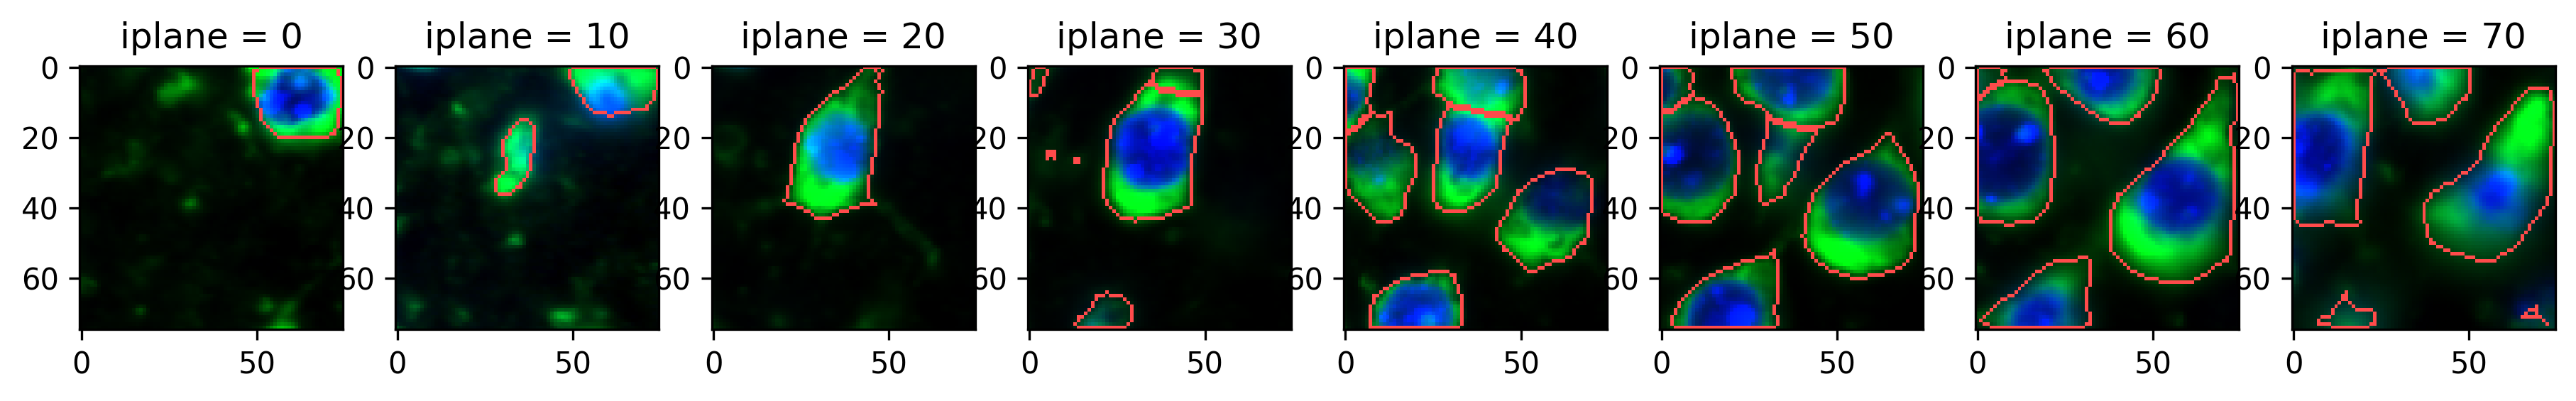

In [9]:
# DISPLAY RESULTS
plt.figure(figsize=(15,3))
for i,iplane in enumerate(np.arange(0,75,10,int)):
  img0 = plot.image_to_rgb(img_3D[iplane, [1,0]].copy(), channels=[2,3])
  plt.subplot(1,8,i+1)
  outlines = utils.masks_to_outlines(masks[iplane])
  outX, outY = np.nonzero(outlines)
  imgout= img0.copy()
  imgout[outX, outY] = np.array([255,75,75])
  plt.imshow(imgout)
  plt.title('iplane = %d'%iplane)

## connect to your google drive

so that you can run your own files (alternatively, upload them directly to the Files tab)

In [ ]:
## RUN THIS CELL TO ACCESS GOOGLE DRIVE

# mount your google drive here if you want to access your own files
from google.colab import drive
drive.mount('/content/drive')

# files will be in
# file_root = '/content/drive/My Drive/'